### Forecasting Mini-Course Sales
特徴量生成と主に線形回帰

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
df_train = pd.read_csv("./data/train.csv", parse_dates=["date"])
df_test = pd.read_csv("./data/test.csv", parse_dates=["date"])
df_subm = pd.read_csv("./data/sample_submission.csv")

In [3]:
df_train.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [14]:
df_test.head()

,id,date,country,store,product
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better


In [15]:
df_subm.head()

,id,num_sold
0,136950,100
1,136951,100
2,136952,100
3,136953,100
4,136954,100


探索的データ分析 (EDA : Exploratory Data Analysis)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4), titlesize=16, titleweight="bold")
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

/tmp/ipykernel_3893/2231712716.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


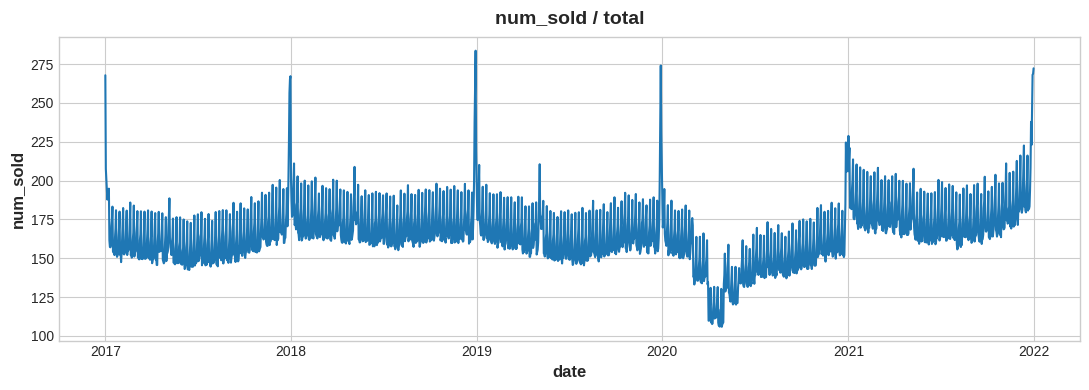

In [36]:
plt.figure(dpi=100)
sns.lineplot(data=df_train, x='date', y='num_sold', errorbar=None) 
plt.title('num_sold / total')
plt.show()

- 年末年始に突出して多い。(4月?)に少し多い。
- 2020年はコロナの影響を受けている。2017年と2021年が似ている。

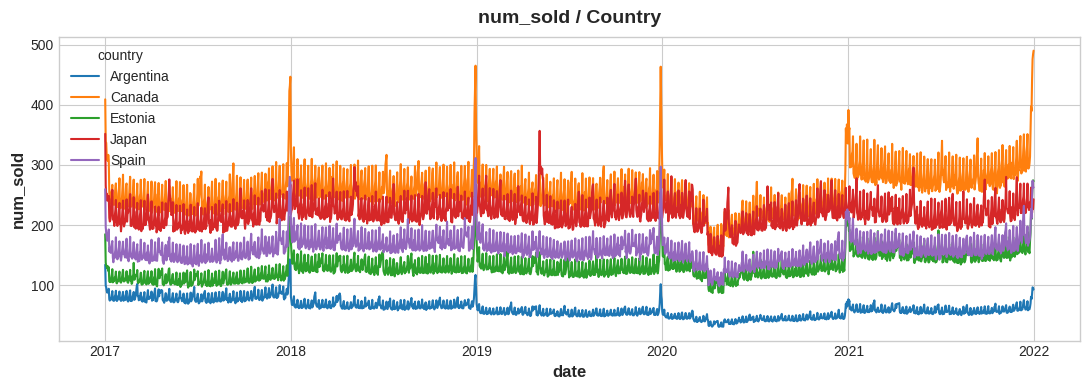

In [37]:
plt.figure(dpi=100)
sns.lineplot(data=df_train, x='date', y='num_sold', hue="country", errorbar=None) 
plt.title('num_sold / Country')
plt.show()

- 大小の差はあれ、国別傾向は似ている
- トータルの傾向分析はカナダに引っ張られていたかも

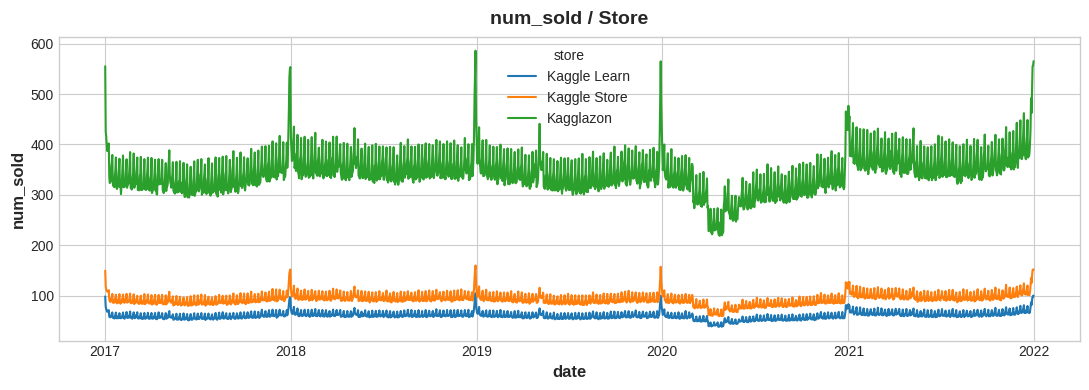

In [38]:
plt.figure(dpi=100)
sns.lineplot(data=df_train, x='date', y='num_sold', hue="store", errorbar=None) 
plt.title('num_sold / Store')
plt.show()

- 数に関しては店舗の差が大きい

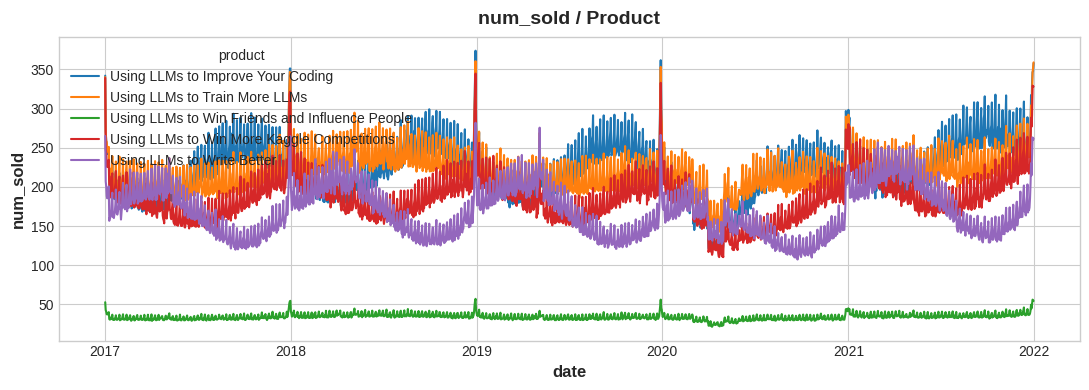

In [39]:
plt.figure(dpi=100)
sns.lineplot(data=df_train, x='date', y='num_sold', hue="product", errorbar=None) 
plt.title('num_sold / Product')
plt.show()

- 季節によって製品の差が大きい
- `Write Better`は年末年始そこまで多くない
- `Win Friends and.`は他と異なる傾向

<font color="tomato">2020年は新型コロナウィルスの影響を受けていそう。学習に使わないことも検討。</font>

モデリング1 (base : https://www.kaggle.com/code/akioonodera/ps-3-19-lgbm-reg)
- 国、店舗、製品をダミー変数化(one-hotエンコード)
- 日付を年、月、日、曜日、etc.に分ける

In [5]:
# 一旦データ結合
df_all = pd.concat([df_train, df_test], ignore_index=True)
# ダミー変数化 (対象カラムは消えます)
df_all = pd.get_dummies(df_all, columns=["country", "store", "product"])
# 日付分割
df_all["year"] = df_all["date"].dt.year
df_all["month"] = df_all["date"].dt.month
df_all["day"] = df_all["date"].dt.day
df_all['dayofyear'] = df_all['date'].dt.day_of_year
df_all['dayofweek'] = df_all['date'].dt.dayofweek
# df_all['weekofyear'] = df_all['date'].dt.weekofyear    # メソッド無い
df_all['weekofyear'] = df_all['date'].apply(lambda x: x.isocalendar()[1])
df_all['quarter'] = df_all['date'].dt.quarter
# df_all['is_weekend'] = df_all['dayofweek'].apply(lambda x: 1 if x in [5, 6] else 0)
df_all['is_weekend'] = df_all['dayofweek'] >= 5
df_all['is_month_end'] = df_all['date'].dt.is_month_end
df_all['is_month_start'] = df_all['date'].dt.is_month_start
df_all['is_quarter_end'] = df_all['date'].dt.is_quarter_end
df_all['is_quarter_start'] = df_all['date'].dt.is_quarter_start
df_all['is_year_end'] = df_all['date'].dt.is_year_end
df_all['is_year_start'] = df_all['date'].dt.is_year_start

In [6]:
df_all.head()

,id,date,num_sold,country_Argentina,country_Canada,country_Estonia,country_Japan,country_Spain,store_Kagglazon,store_Kaggle Learn,...,dayofweek,weekofyear,quarter,is_weekend,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,0,2017-01-01,63.0,True,False,False,False,False,False,True,...,6,52,1,True,False,True,False,True,False,True
1,1,2017-01-01,66.0,True,False,False,False,False,False,True,...,6,52,1,True,False,True,False,True,False,True
2,2,2017-01-01,9.0,True,False,False,False,False,False,True,...,6,52,1,True,False,True,False,True,False,True
3,3,2017-01-01,59.0,True,False,False,False,False,False,True,...,6,52,1,True,False,True,False,True,False,True
4,4,2017-01-01,49.0,True,False,False,False,False,False,True,...,6,52,1,True,False,True,False,True,False,True


In [67]:
# # (LinearRegression用？) 型変換　⇒　変わらなかった
# bool_cols = [col for col in df_all.columns if df_all[col].dtype == "bool"]
# df_all[bool_cols] = df_all[bool_cols].astype("int32")

In [7]:
# トレーニングとテストに分割
train = df_all[~df_all["num_sold"].isna()]
test = df_all[df_all["num_sold"].isna()]

学習

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [6]:
def smape(train, feat_ary, target, model):
    """SMAPE : https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error"""
    pred = model.predict(train[feat_ary])
    true = train[target]
    return 100/len(true) * np.sum(2 * np.abs(pred - true) / (np.abs(pred) + np.abs(true)))

In [68]:
# # 2020年削除してみる　⇒ ざっくりだけど、除かない方がRMSE良かった
# train_bak = train.copy()
# train = train[train["year"]!=2020]

# train = train_bak.copy()

In [9]:
# X = train.drop(columns=["id", "date", "num_sold"])
# y = train["num_sold"].astype("int")
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

# ランダムではなく、2021年予測に変更。 (更に過去の売上げは使ってもいい？ ⇒ 学習に使えないのでダメ)
# ⇒ 過去の売上げを何か変換して特徴量として持たせる方が良い。
X = train.drop(columns=["id", "date", "num_sold"])
y = train["num_sold"].astype("int")
X_train = X[X["year"].isin([2017, 2018, 2019, 2020])]
y_train = y[:len(X_train)]
X_test = X[X["year"] == 2021]
y_test = y[len(X_train):]

print(f"train shape: {X_train.shape}, test shape: {X_test.shape}")

train shape: (109575, 28), test shape: (27375, 28)


In [10]:
X_train.head()

,num_sold,country_Argentina,country_Canada,country_Estonia,country_Japan,country_Spain,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,...,dayofweek,weekofyear,quarter,is_weekend,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,63.0,True,False,False,False,False,False,True,False,True,...,6,52,1,True,False,True,False,True,False,True
1,66.0,True,False,False,False,False,False,True,False,False,...,6,52,1,True,False,True,False,True,False,True
2,9.0,True,False,False,False,False,False,True,False,False,...,6,52,1,True,False,True,False,True,False,True
3,59.0,True,False,False,False,False,False,True,False,False,...,6,52,1,True,False,True,False,True,False,True
4,49.0,True,False,False,False,False,False,True,False,False,...,6,52,1,True,False,True,False,True,False,True


In [11]:
model = LinearRegression()
model.fit(X_train, y_train)
# y_fit = pd.Series(model.predict(X_train), index=y_train.index)
# y_pred = pd.Series(model.predict(X_test), index=y_test.index)
y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index)
df_fit = y_fit.reset_index()
df_fit.columns = ["id", "fit"]
df_pred = y_pred.reset_index()
df_pred.columns = ["id", "pred"]

In [12]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.3f}\n" f"Test RMSE:  {test_rmse:.3f}"))

Train RMSE: 0.000
Test RMSE:  0.000


https://docs.bokeh.org/en/latest/docs/examples/basic/annotations/legend.html

In [23]:
# 結果確認用グラフ出力
from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_notebook, show, save, output_file, reset_output
from bokeh.palettes import d3

W, H = 1000, 300
TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

def make_trend(df, c_column, title):
    """plotオブジェクト生成"""
    c = d3['Category10'][df[c_column].nunique()]
    p = figure(title=title, x_axis_type="datetime", height=H, width=W, tools=TOOLS)
    for i, col in enumerate(df[c_column].unique()):
        df_tmp = df[df[c_column]==col][["date", "num_sold", "fit", "pred"]]
        p.line("date", "num_sold", source=df_tmp, line_color=c[i], legend_label=col)
        p.circle("date", "fit", source=df_tmp, fill_color=c[i], line_color=c[i], legend_label=col)
        p.square("date", "pred", source=df_tmp, fill_color=None, line_color=c[i], legend_label=col)
    p.legend.click_policy = "hide"
    return p

In [24]:
df_plot = df_train.merge(df_fit, how="left").merge(df_pred, how="left")
df_plot.head()

,id,date,country,store,product,num_sold,fit,pred
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,78.864982,NaN
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,77.994573,NaN
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,-104.397761,NaN
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,43.105274,NaN
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49,26.389417,NaN


In [29]:
# country は関数内で色分け対象
plots = []
for prod in df_plot["product"].unique():
    for store in df_plot["store"].unique():
        df_buf = df_plot[(df_plot["product"]==prod) & (df_plot["store"]==store)].drop(columns=["product", "store"]).reset_index(drop=True)
        p = make_trend(df_buf, "country", f"{prod[14:]} ({store})")
        plots.append(p)

In [30]:
reset_output() # output_notebook()の効果を消す
output_file("graph.html", title="trend of the predict") # 出力先の設定
save(gridplot(plots, ncols=1)) # グラフを保存するだけ
# show(gridplot(plots, ncols=1)) # 保存した上でブラウザを開く

'/mnt/b/python/meitec_教訓研修/Mini-Course_Sales/graph.html'

一応submitしてみる

In [82]:
result = pd.DataFrame(model.predict(test.drop(columns=["id", "date", "num_sold"])), index=test.index)

In [83]:
df_subm["num_sold"] = result.values
df_subm.head()

,id,num_sold
0,136950,79.558662
1,136951,76.910843
2,136952,-107.070135
3,136953,43.419492
4,136954,26.158982


In [84]:
df_subm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27375 entries, 0 to 27374
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        27375 non-null  int64  
 1   num_sold  27375 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 427.9 KB


In [86]:
df_subm.to_csv("./Mini-Course_Sales/submission.csv", index=False)

scored 73.99379

- 2020年を入れる/入れない
- 製品毎に学習させる　⇒ 製品もダミー変数化してるから織り込み済み？
- 学習時のテスト対象を各年でやってみる(2020年を除く)